<a href="https://colab.research.google.com/github/Darshan-Thakar/Darshan-Thakar/blob/main/Age_Predictor_%7C_UTKFace_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/root/kaggle.json ~/.kaggle

In [ ]:
!pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

!chmod 6000 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

100% 331M/331M [00:12<00:00, 31.2MB/s]
100% 331M/331M [00:12<00:00, 27.5MB/s]


In [ ]:
!unzip utkface-new.zip;


Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [ ]:
# Importing the required packages
import numpy as np
import pandas as pd
from tensorflow import keras
import sklearn as sk
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# Preprocessing the images i.e Getting Age and Gender from the Image path

df=pd.DataFrame();
Age=[];
Gender=[];
Images=[];
for image in os.listdir("/content/UTKFace"):
    Age.append(int(image.split("_")[0]));
    Gender.append(int(image.split("_")[1]));
    Images.append(image);



In [ ]:
df=pd.DataFrame({'Age':Age,'Gender':Gender,'Images':Images});

In [ ]:
# Having a look at the dataset
df.head(4)

,Age,Gender,Images
0,28,1,28_1_4_20170103182238570.jpg.chip.jpg
1,2,1,2_1_2_20161219160405349.jpg.chip.jpg
2,68,0,68_0_0_20170113185525480.jpg.chip.jpg
3,31,0,31_0_1_20170113175708996.jpg.chip.jpg


<Axes: xlabel='Gender', ylabel='count'>

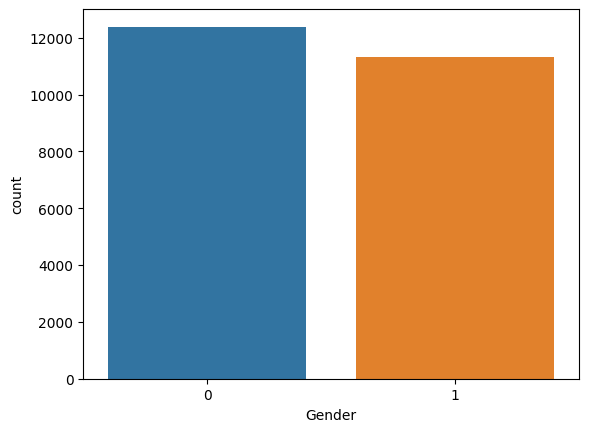

In [ ]:

# Now we will peform some initial analysis on the dataset

# 1) Checking the distribution of males and females

sns.countplot(x='Gender',data=df)

We can conclude from the above graph that the distribution of the gender is almost equal.

In [ ]:
df['Age'].value_counts()

26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
91        2
101       2
103       1
111       1
Name: Age, Length: 104, dtype: int64

Now we will Train Test Split the Dataset

In [ ]:
# Imports
from sklearn.model_selection import train_test_split

X_train,X_test=train_test_split(df,test_size=0.2,random_state=1000);


Now we will apply Data Augmentation using ImageDataGenerator Keras

In [ ]:
# Importing the required things
from keras.preprocessing.image import ImageDataGenerator

train_gen=ImageDataGenerator(
    rescale=1./255.,
    height_shift_range=0.2,
    width_shift_range=0.23,
    rotation_range=20,
    shear_range=0.1
)

In [ ]:
test_gen=ImageDataGenerator(
    rescale=1./255.
)

In [ ]:
train_data=train_gen.flow_from_dataframe(X_train,directory="/content/UTKFace",batch_size=32,x_col="Images",y_col=["Age","Gender"],class_mode='multi_output');
test_data=train_gen.flow_from_dataframe(X_test,directory="/content/UTKFace",x_col="Images",y_col=["Age","Gender"],class_mode='multi_output');

Found 18966 validated image filenames.
Found 4742 validated image filenames.


Applying Transfer Learning using MobileNet Model with Fine_tuning

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Imports
from tensorflow.keras.applications import MobileNet

mobilenet=MobileNet(weights='imagenet',include_top=False,input_shape=(256,256,3));


17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
mobilenet.trainable=False;

In [ ]:
for layer in mobilenet.layers[75:]:
  layer.trainable=True

In [ ]:
from keras.models import Model
from keras.layers import *

In [ ]:
#New Convolution layer
Input=InputLayer((256,256,3));
conv1=Conv2D(64,kernel_size=(3,3),activation='relu')(Input.output);
max1=MaxPooling2D((2,2))(conv1);
conv2=Conv2D(128,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal')(max1);
max2=MaxPooling2D((2,2))(conv2);
conv3=Conv2D(256,kernel_size=(2,2),activation='relu',kernel_initializer='he_uniform')(max2);
conv4=Conv2D(512,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal')(conv3);
max4=MaxPooling2D((2,2))(conv4);
conv5=Conv2D(1024,kernel_size=(3,3),activation='relu')(max4);
max5=MaxPooling2D((2,2))(conv5);
# Branching the convolutional layers output into two branches (One will apply global average pooling and the other will apply flatten layer)
global_pool_concat_1 = GlobalAveragePooling2D()(max5)
flatten_concat_1 = Flatten()(max5)

# Now we will concatenate it again
concat_2=Concatenate()([global_pool_concat_1,flatten_concat_1]);

# Now we will split it into four branches of Dense layer 1st two for age prediction and the 2nd two branches for Gender classification

#2nd branch (Dense)
dense_1_branch_2=Dense(256,activation='relu',kernel_initializer='he_normal',name="Dense_1_Branch_2")(concat_2);

drop_1_branch_2=Dropout(0.5)(dense_1_branch_2);

BatchNormalization_1_branch_2=BatchNormalization()(drop_1_branch_2);

dense_2_branch_2=Dense(128,activation='tanh',name="Dense_2_Branch_2")(BatchNormalization_1_branch_2);




#1st branch (Dense)
dense_1_branch_1=Dense(128,activation='relu',kernel_initializer='he_normal',name="Dense_1_Branch_1")(concat_2);

drop_1_branch_1=Dropout(0.5)(dense_1_branch_1);

BatchN_1_branch_1=BatchNormalization()(drop_1_branch_1);

dense_2_branch_1=Dense(84,activation='relu',kernel_initializer='he_normal',name="Dense_2_Branch_1")(BatchN_1_branch_1);

drop_2_branch_1=Dropout(0.5)(dense_2_branch_1);

BatchN_2_branch_1=BatchNormalization()(drop_2_branch_1);

dense_3_branch_1=Dense(128,activation='relu',kernel_initializer='he_normal',name="Dense_3_Branch_1")(BatchN_2_branch_1);

drop_3_branch_1=Dropout(0.5)(dense_3_branch_1);

BatchN_3_branch_1=BatchNormalization()(drop_3_branch_1);

AddLayer_1_branch_1=Add()([BatchN_3_branch_1,dense_1_branch_1,dense_2_branch_2]);

Age_Output=Dense(1,activation='linear',name="age_output")(AddLayer_1_branch_1);



#3rd Branch (Dense)

dense_1_branch_3=Dense(84,activation='relu',name="Dense_1_Branch_3")(concat_2);

drop_1_branch_3=Dropout(0.5)(dense_1_branch_3);

BN_1_branch_3=BatchNormalization()(drop_1_branch_3);

dense_2_branch_3=Dense(32,activation='relu',name="Dense_2_Branch_3")(BN_1_branch_3);


#4th Branch (Dense)

dense_1_branch_4=Dense(84,activation='relu',name="Dense_1_Branch_4")(concat_2);

drop_1_branch_4=Dropout(0.5)(dense_1_branch_4);

BN_1_branch_4=BatchNormalization()(drop_1_branch_4);

dense_2_branch_4=Dense(84,activation='relu',name="Dense_2_Branch_4",kernel_initializer='he_normal')(BN_1_branch_4);

add_1_branch_4=Add()([dense_2_branch_4,dense_1_branch_3]);

# Merging two branches (Branch 3 and Branch 4)
concat_3=Concatenate()([add_1_branch_4,dense_2_branch_3]);

dense_1_merged_branch=Dense(32,activation='relu',kernel_initializer='he_normal')(concat_3);

Gender_output=Dense(1,activation='sigmoid',name='Gender_output')(dense_1_merged_branch);







In [ ]:
facenet=Model(inputs=Input.output,outputs=[Age_Output,Gender_output]);

In [ ]:
#Compiling the model

facenet.compile(
    optimizer='adam',
    loss={'Gender_output':'binary_crossentropy','age_output':'mae'},
    metrics={'Gender_output':'accuracy','age_output':'mae'}
)

In [ ]:
# Imports
from keras.utils import plot_model

# Model summary
facenet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 254, 254, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 127, 127, 64  0          ['conv2d_11[0][0]']              
                                )                                                           

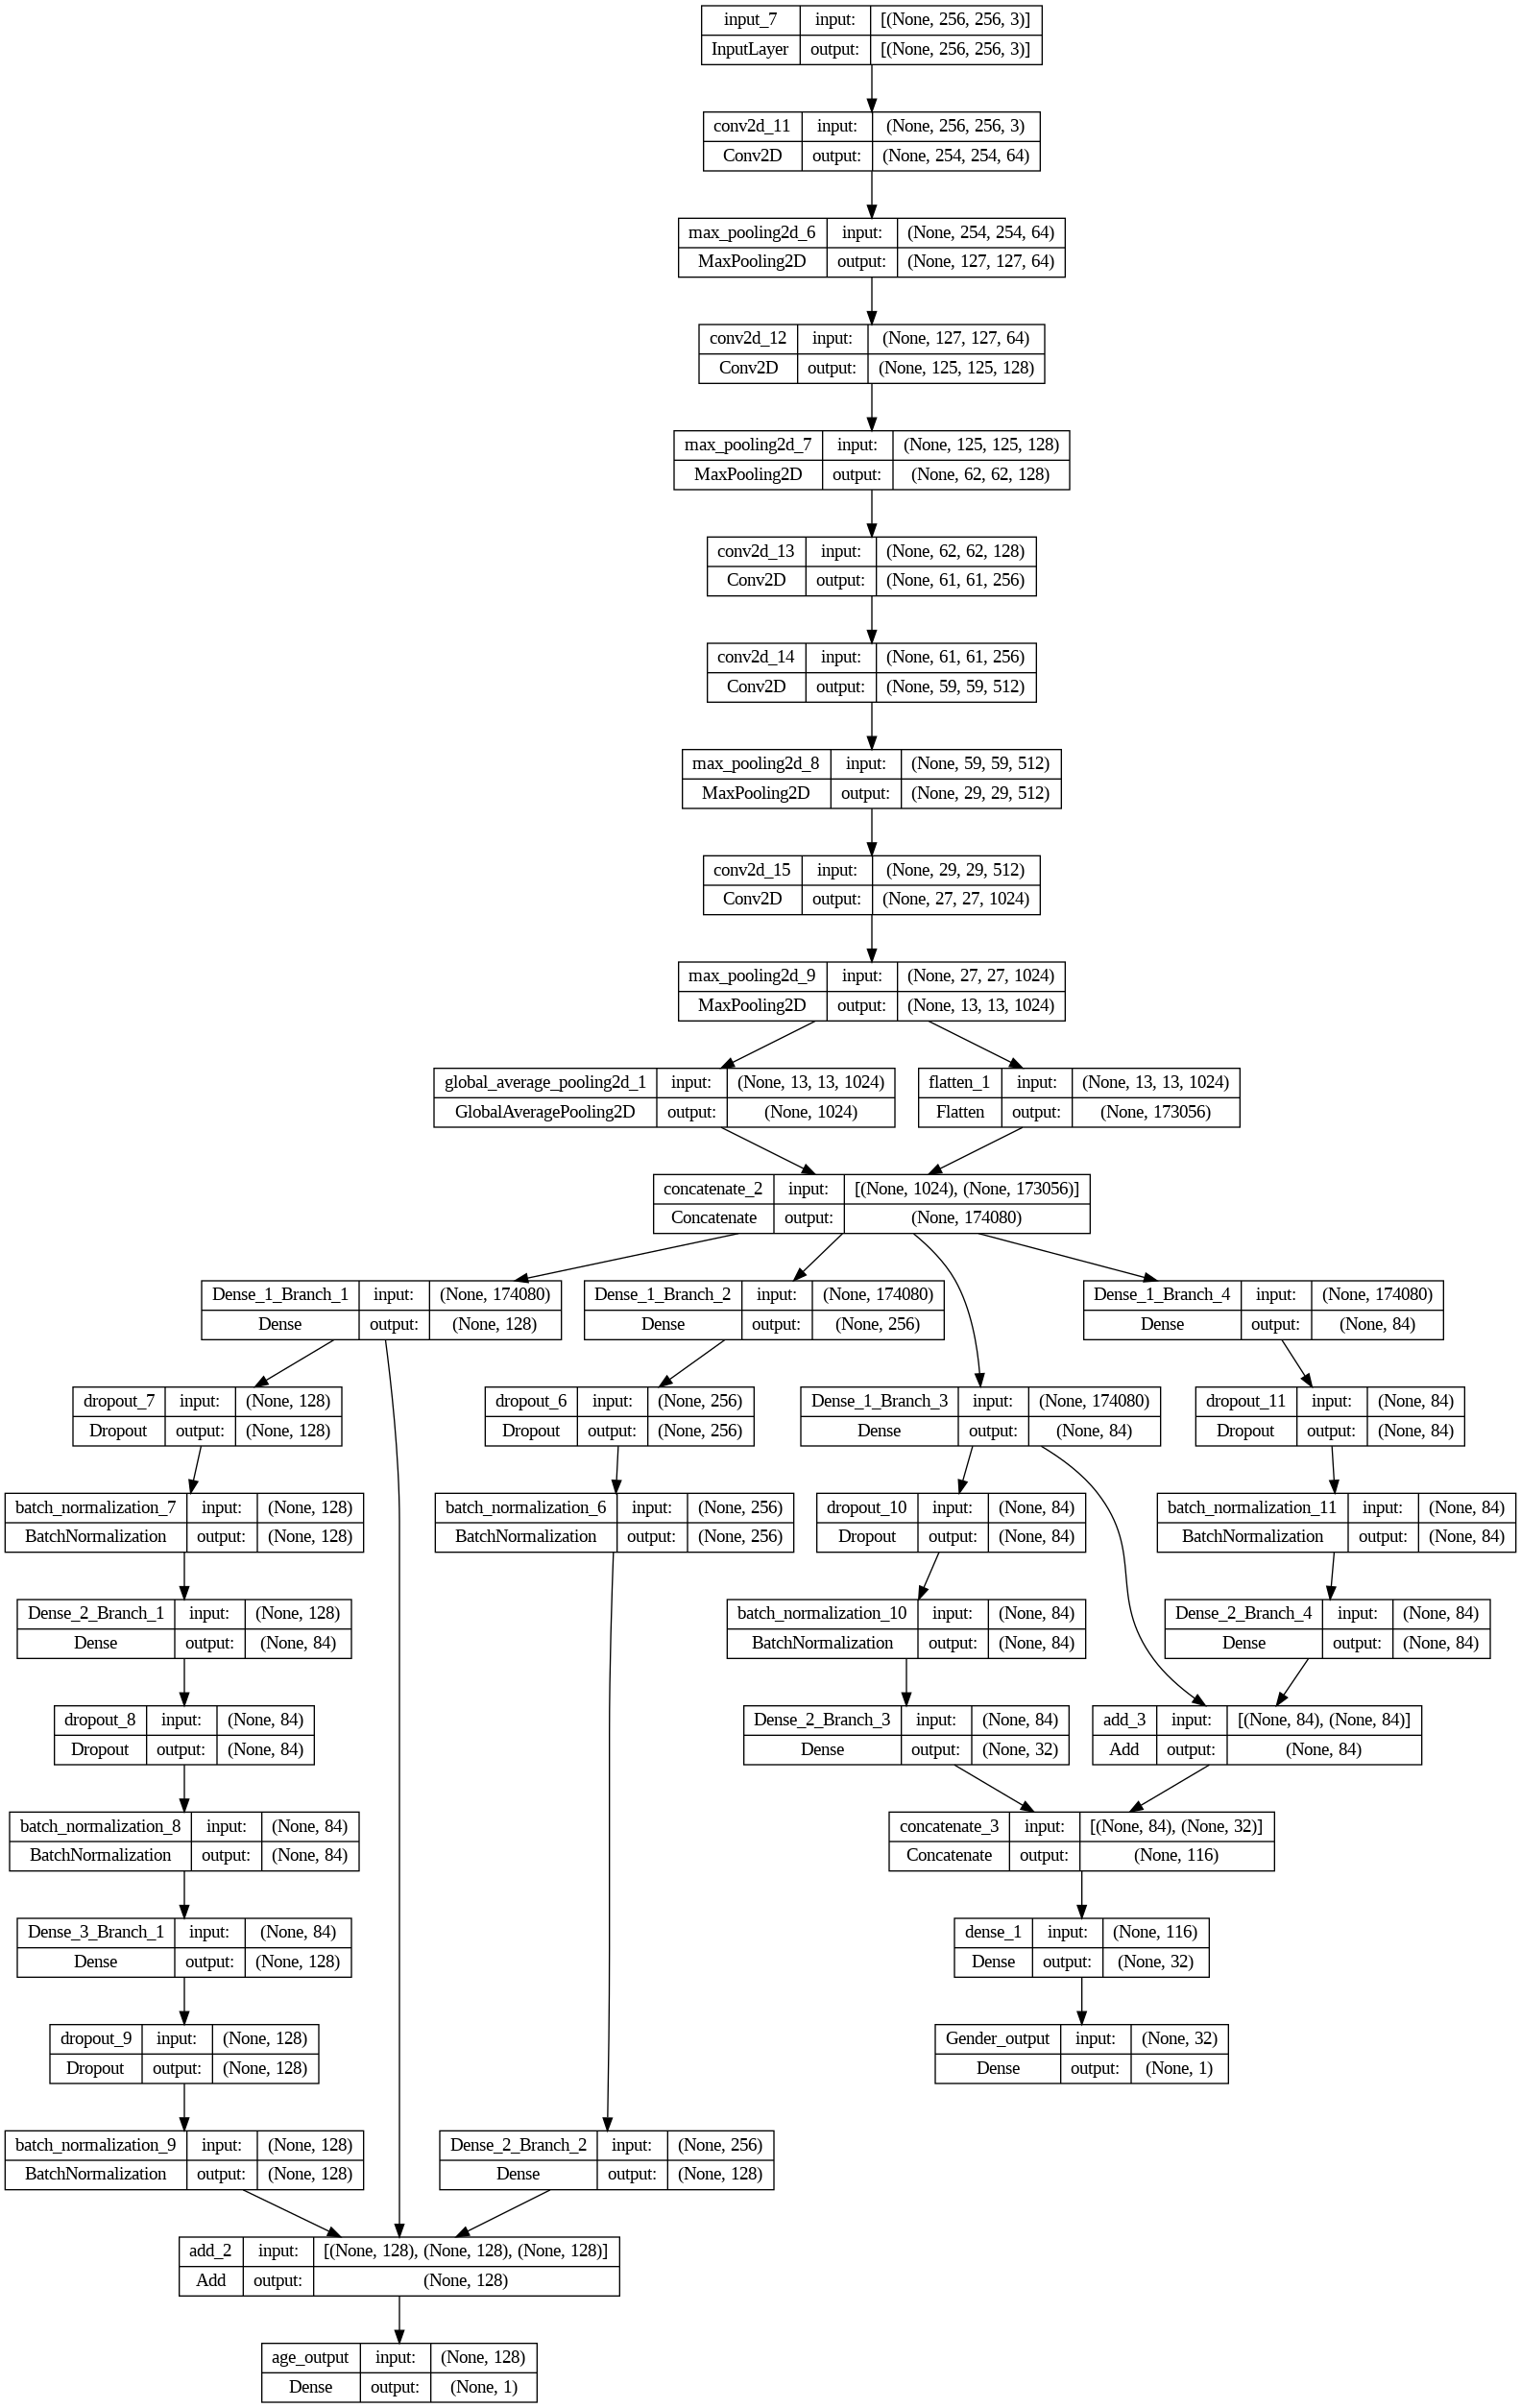

In [ ]:
#Plotting the model
plot_model(facenet,show_shapes=True)

In [ ]:
from keras.callbacks import EarlyStopping,LearningRateScheduler

callback=EarlyStopping(
    monitor='val_loss',
    mode='auto',
    patience=5,
    min_delta=0.1,
    baseline=None,
    verbose=1
)
def lr_schedule(epoch,lr):
  if (epoch<5):
    lr=0.01;
  elif(epoch<13):
    lr=(epoch-4)*0.1*0.09;

  else:
      lr=0.001;
  return lr
callback2=LearningRateScheduler(lr_schedule)

In [ ]:
history=facenet.fit(train_data,validation_data=test_data,epochs=20,verbose=1,callbacks=[callback,callback2]);

Epoch 1/20
 16/593 [..............................] - ETA: 5:12 - loss: 193.9118 - age_output_loss: 192.6898 - Gender_output_loss: 1.2221 - age_output_mae: 192.6898 - Gender_output_accuracy: 0.5371

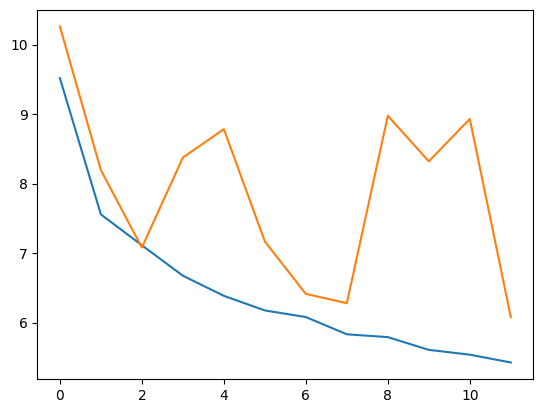

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['age_output_mae']);
plt.plot(history.history['val_age_output_mae'])

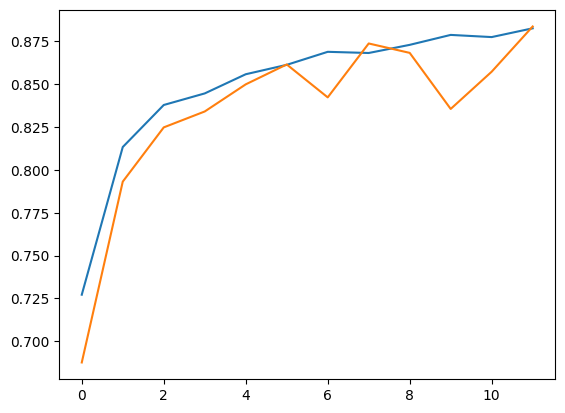

In [ ]:
plt.plot(history.history['Gender_output_accuracy']);
plt.plot(history.history['val_Gender_output_accuracy'])


In [ ]:
import pickle

In [ ]:
with open("facenet.h5",'wb') as fb:
  pickle.dump(facenet,fb);

In [ ]:
y_pred=facenet(test_data[0][0])

In [ ]:
y_pred[0]

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[31.061356 ],
       [34.20171  ],
       [57.971584 ],
       [21.357004 ],
       [33.455494 ],
       [59.52531  ],
       [33.393272 ],
       [15.058602 ],
       [39.068077 ],
       [59.31014  ],
       [30.237738 ],
       [56.14663  ],
       [27.17233  ],
       [33.89708  ],
       [28.452393 ],
       [29.828245 ],
       [29.579893 ],
       [63.828957 ],
       [ 3.5527122],
       [33.33551  ],
       [ 1.346612 ],
       [32.904953 ],
       [30.919624 ],
       [46.6616   ],
       [28.660069 ],
       [49.258434 ],
       [34.758835 ],
       [54.727547 ],
       [ 1.3386402],
       [37.29332  ],
       [32.652554 ],
       [43.448948 ]], dtype=float32)>

In [ ]:
Gender_predictions=[np.round(i) for i in y_pred[1]];

In [ ]:
test_data[0][1]

[array([30, 29, 57,  9, 46, 73, 29, 18, 39, 60, 29, 59, 24, 28, 22, 27, 21,
        67,  7, 32,  2, 27, 26, 45, 30, 56, 28, 65,  1, 38, 28, 65]),
 array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 0])]

In [ ]:
Gender_predictions

[array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32)]

In [ ]:
ebatch=test_data[0][0];

In [ ]:
sample=batch[-30]

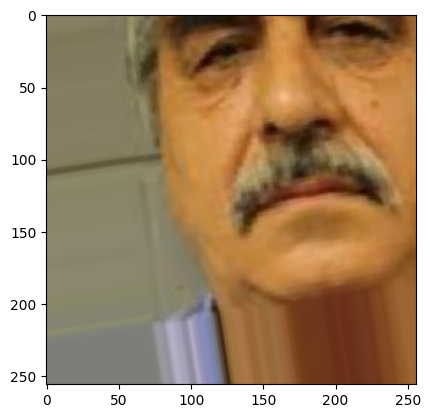

In [ ]:
plt.imshow(sample)